In [1]:
import numpy as np
import pandas as pd
import joblib # Para guardar modelo

# Datos
from sklearn import preprocessing
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RepeatedStratifiedKFold
)

# MODELO
import xgboost as xgb

# EVALUACION
from sklearn.metrics import (
    roc_auc_score as roc_auc, 
    precision_score as precision,  
    f1_score as f1, 
    recall_score as recall,
    accuracy_score as accuracy, 
    brier_score_loss as brier_loss, 
    average_precision_score as average_precision, 
    fbeta_score as fbeta,
    make_scorer,
    classification_report
)

from scipy.stats import ks_2samp

# OPTIMIZACION
from sklearn.model_selection import RandomizedSearchCV

# Funciones Varias

In [2]:
def f2(y_true, y_pred):
    return fbeta(y_true=y_true, y_pred=y_pred, beta=2, average='macro')


def f05(y_true, y_pred):
    return fbeta(y_true=y_true, y_pred=y_pred, beta=0.5, average='macro')


def ks_stat(y, yhat):
    """
    Métrica de KS
    """
    return ks_2samp(yhat[y == 1], yhat[y != 1]).statistic

def eval_model_cv(X, y, model, metricas_, n_splits_=6, n_repeats_=5):
    """
    Evaluación del modelo en cross validation, con N folds y N repeticiones.
    """
    cv = RepeatedStratifiedKFold(
        n_splits=n_splits_, n_repeats=n_repeats_, random_state=42
    )
    scores = cross_validate(model, X, y, scoring=metricas_, cv=cv)
    eval_df = pd.DataFrame(scores)
  

    tabla = (
        eval_df.drop(["fit_time", "score_time"], axis=1)
        .rename(columns=lambda x: x.replace('test_', ''))
        .describe()
        .T.drop("count", axis=1)
        #.style.format(precision=2)
    )

    dicc = tabla['mean'].round(2).to_dict()
    dicc = {x.replace('test_', ''): v for x, v in dicc.items()}

    tabla = tabla.style.format(precision=2)


    return tabla, dicc

def metrics(y, X, pipe):
    metrics_inferences = {
        precision: "label",
        recall: "label",
        f1: "label",
        f05: "label",
        f2: "label",
        accuracy: "label",
        roc_auc: "proba",
    }
    
    preds = pd.DataFrame(
                        {"y_true": y, 
                        "y_pred_prob": [i[1] for i in pipe.predict_proba(X)], 
                        "y_pred_class": pipe.predict(X)}
                    )
    preds.fillna(0)
    
    test_metrics = {}
    test_metrics['precision'] = precision(preds["y_true"], preds["y_pred_class"], average='macro')
    test_metrics['recall'] = recall(preds["y_true"], preds["y_pred_class"], average='macro')
    test_metrics['f1'] = f1(preds["y_true"], preds["y_pred_class"], average='macro')
    test_metrics['f05'] = f05(preds["y_true"], preds["y_pred_class"])
    test_metrics['f2'] = f2(preds["y_true"], preds["y_pred_class"])
    test_metrics['accuracy'] = accuracy(preds["y_true"], preds["y_pred_class"])        

    del preds

    table_metrics = pd.DataFrame({'metrica':test_metrics.keys(), 'valor':test_metrics.values()})
    table_metrics['valor'] = round(table_metrics['valor'],2)

    return table_metrics, test_metrics


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import set_matplotlib_formats

def plot_matrix_confusion(X_test,y_test,le,model):
    y_pred = model.predict(X_test)

    conf_mat = confusion_matrix(y_test, y_pred)
    #Valores normalizados
    conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    # Crear una figura con un tamaño personalizado

    plt.figure(figsize=(16, 16))
    ax= plt.subplot()
    sns.heatmap(conf_mat_norm, annot=True,fmt='.2f',cmap="OrRd")

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(le.classes_) 
    ax.yaxis.set_ticklabels(le.classes_)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")

    plt.show()

def reporting_table(y_test,y_pred,le):
    report = classification_report(y_test, y_pred, target_names=le.classes_,output_dict=True,digits=2)
    df_report = pd.DataFrame(report).transpose().round(2)
    return df_report.style.background_gradient(axis=None, subset=pd.IndexSlice[le.classes_[0]:le.classes_[-1], :df_report.columns[-2]],cmap="OrRd").set_precision(2) 


metricas = {
  #'ks_stat' : make_scorer(ks_stat, needs_proba=True, greater_is_better=True),
  'precision' : make_scorer(precision, zero_division = 0, average='macro'),
  'recall': make_scorer(recall,average='macro'),
  'f1' : make_scorer(f1, average='macro'),
  'f05' : make_scorer(f05),
  'f2' : make_scorer(f2),
  'roc_auc' : make_scorer(roc_auc, needs_proba = True, multi_class='ovr'),
  'accuracy': make_scorer(accuracy),
  #'average_precision' : make_scorer(average_precision_score, average='macro'),
  #'brier_loss' : make_scorer(brier_score_loss, needs_proba = True, average='macro'),
  #'log_loss' : make_scorer(log_loss, needs_proba=True, average='macro')
}

# Parámetros

In [3]:
OPTIMIZAR = False
best_params = None

# Datos

In [4]:
df = pd.read_parquet('../01_datos/01_criterios/criterio_random_10fr_no_face.parquet')

# Encoder
le = preprocessing.LabelEncoder()
le.fit(df['sign'])
df['target'] = le.transform(df['sign'])
df.drop('sign',axis=1, inplace=True)
df.head()

,fr_0_pose_p0_x,fr_0_pose_p0_y,fr_0_pose_p1_x,fr_0_pose_p1_y,fr_0_pose_p2_x,fr_0_pose_p2_y,fr_0_pose_p3_x,fr_0_pose_p3_y,fr_0_pose_p4_x,fr_0_pose_p4_y,...,fr_9_right_hand_p16_y,fr_9_right_hand_p17_x,fr_9_right_hand_p17_y,fr_9_right_hand_p18_x,fr_9_right_hand_p18_y,fr_9_right_hand_p19_x,fr_9_right_hand_p19_y,fr_9_right_hand_p20_x,fr_9_right_hand_p20_y,target
0,0.532868,0.286838,0.548387,0.250000,0.557093,0.250409,0.564684,0.251573,0.518099,0.248068,...,0.386130,0.426423,0.490539,0.424275,0.458936,0.423810,0.437550,0.423738,0.418148,3
1,0.525415,0.296511,0.540164,0.259468,0.550312,0.260586,0.558320,0.261637,0.510657,0.260522,...,0.410465,0.433397,0.515740,0.422078,0.489677,0.415374,0.471019,0.410164,0.453710,3
2,0.528207,0.300307,0.542332,0.264797,0.552436,0.266064,0.560215,0.267269,0.513824,0.263970,...,0.421466,0.440995,0.525876,0.430971,0.500801,0.425215,0.483139,0.420960,0.466409,3
3,0.529540,0.306016,0.544009,0.268261,0.554265,0.268905,0.562328,0.270008,0.515907,0.267245,...,0.418498,0.455433,0.522799,0.444785,0.498641,0.438589,0.481068,0.433860,0.464379,3
4,0.529684,0.313428,0.543518,0.274926,0.553503,0.274682,0.561523,0.274850,0.516094,0.273063,...,0.429658,0.464094,0.530552,0.454496,0.506470,0.448543,0.488854,0.443813,0.472008,3


In [5]:
X = df.drop(['target'],axis=1)
y = df['target']

SEED = 42
TEST_SIZE = 0.2
VALID_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    stratify=y, 
                                                    test_size=TEST_SIZE,
                                                    random_state=SEED, 
                                                    shuffle=True,
                                                )

X_train, X_valid, y_train, y_valid = train_test_split(
                                                    X_train,
                                                    y_train,
                                                    stratify=y_train, 
                                                    test_size=VALID_SIZE,
                                                    random_state=SEED, 
                                                    shuffle=True,
                                                )

print(f"{'{ Params modelo }':=^80}")
print(f"{'Proporción partición train: '+str(round(1 - TEST_SIZE - VALID_SIZE,2)):-<80}")
print(f"{'Proporción partición test: '+str(round(TEST_SIZE,2)):-<80}")
print(f"{'Proporción partición validacion: '+str(round(VALID_SIZE,2)):-<80}")

==============================={ Params modelo }================================
Proporción partición train: 0.6-------------------------------------------------
Proporción partición test: 0.2--------------------------------------------------
Proporción partición validacion: 0.2--------------------------------------------


# Modelado

In [6]:
# Definicion de modelo xgboost base
modelxgb_base = xgb.XGBClassifier(seed = SEED)
modelxgb_base.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

## CrossValidate

In [7]:
%%time
# Cross-validation
cv_metrics_xgb_ajuste, cv_mean_metrics_rl_ajuste= eval_model_cv(X=X_train, y=y_train, model=modelxgb_base, metricas_=metricas)
cv_metrics_xgb_ajuste

CPU times: total: 27min 38s
Wall time: 3min 53s


,mean,std,min,25%,50%,75%,max
precision,0.91,0.03,0.85,0.89,0.91,0.94,0.97
recall,0.90,0.03,0.83,0.88,0.91,0.93,0.97
f1,0.90,0.04,0.82,0.88,0.90,0.92,0.96
f05,0.90,0.03,0.84,0.88,0.91,0.93,0.97
f2,0.90,0.04,0.82,0.88,0.90,0.92,0.96
roc_auc,1.00,0.00,0.99,0.99,1.00,1.00,1.00
accuracy,0.90,0.03,0.84,0.88,0.91,0.93,0.96


Un desviación estándar (std) de 0.03 en el resultado de la función cross_validate indica que los resultados de la métrica de evaluación utilizada tienen una variabilidad relativamente baja entre las diferentes divisiones de entrenamiento y prueba durante la validación cruzada.

Esto indica qué tan dispersos están los valores con respecto a la media. En el contexto de la validación cruzada, una desviación estándar baja indica que los resultados de la métrica de evaluación (por ejemplo, precisión, exactitud, puntaje F1, etc.) son consistentes y similares en todas las divisiones de entrenamiento y prueba. Por lo tanto este valor sugiere que el modelo tiene un rendimiento estable y robusto en diferentes conjuntos de datos de entrenamiento y prueba. Esto es deseable, ya que indica que el modelo es menos sensible a la variación en los datos de prueba y es más confiable en términos de su rendimiento general.

## Métricas de test - modelo base

In [8]:
%%time
# Entrenamiento de modelo base y evaluacion con datos de test
test_xgb, test_dicc_xgb= metrics(y_test, X_test, modelxgb_base)
test_xgb

CPU times: total: 484 ms
Wall time: 158 ms


,metrica,valor
0,precision,0.89
1,recall,0.89
2,f1,0.88
3,f05,0.89
4,f2,0.88
5,accuracy,0.89


## Evaluacion de métricas test

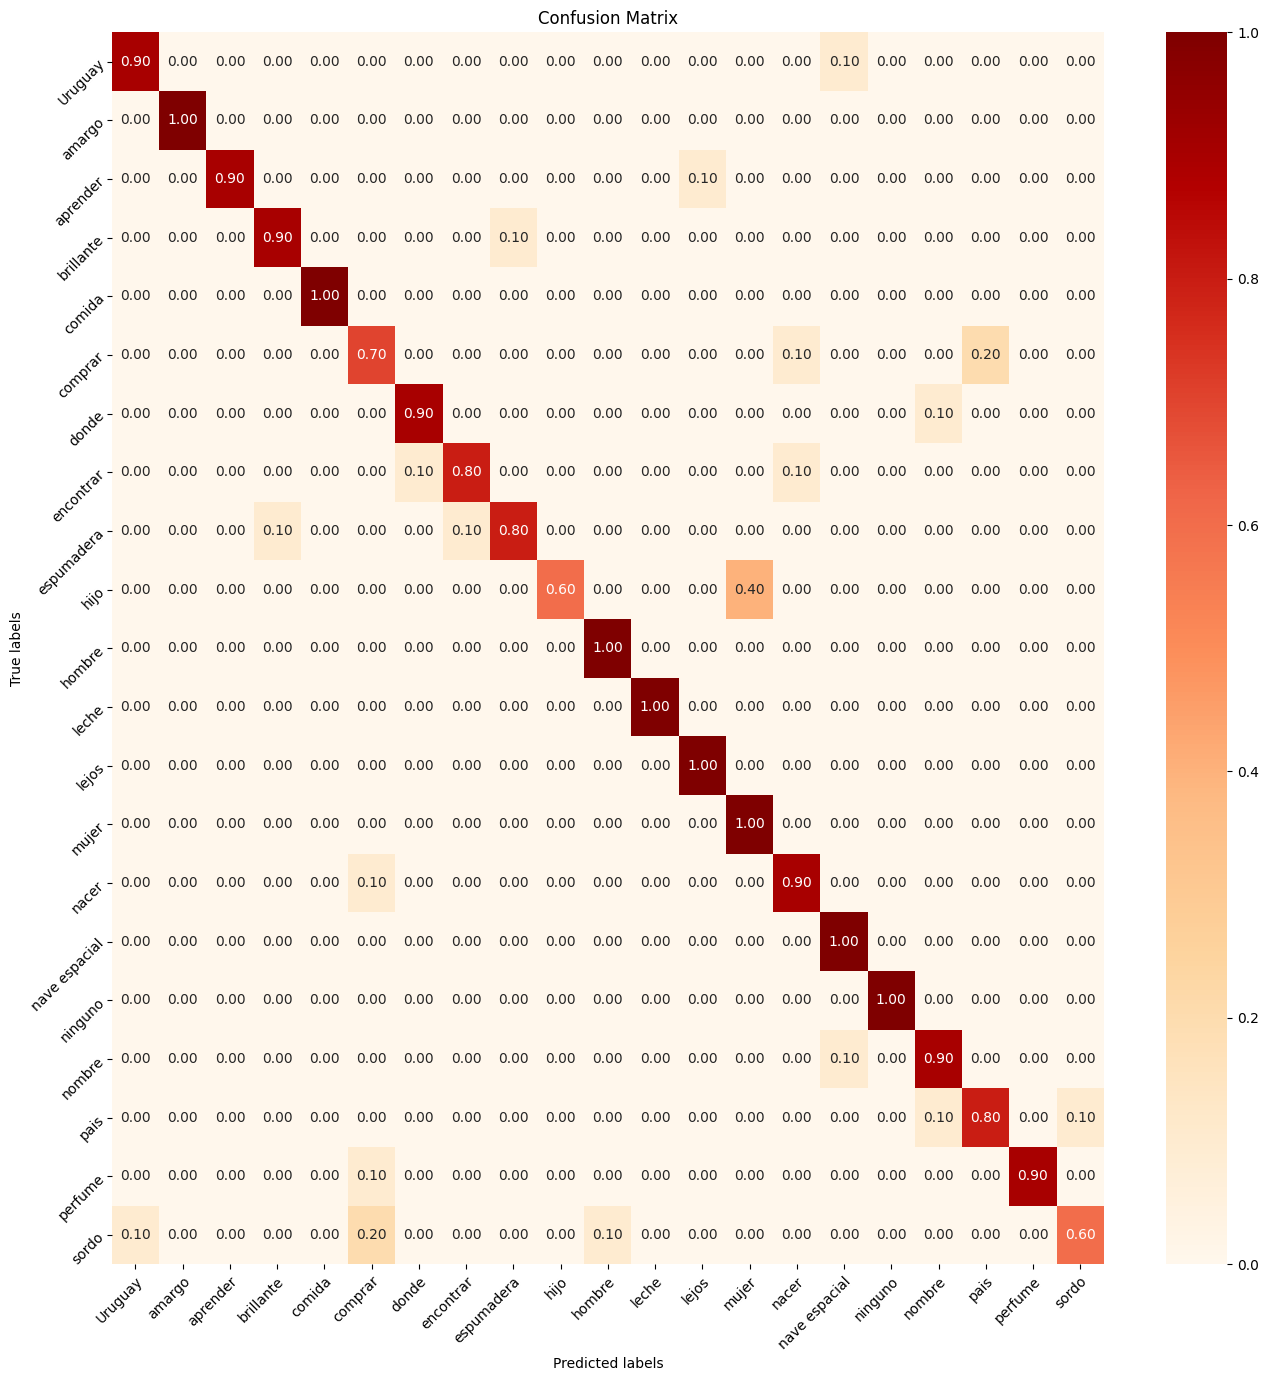

In [9]:
plot_matrix_confusion(X_test,y_test,le,modelxgb_base)

In [10]:
y_pred = modelxgb_base.predict(X_test)
reporting_table(y_test,y_pred,le)

C:\Users\facur\AppData\Local\Temp\ipykernel_4360\2673514020.py:110: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  return df_report.style.background_gradient(axis=None, subset=pd.IndexSlice[le.classes_[0]:le.classes_[-1], :df_report.columns[-2]],cmap="OrRd").set_precision(2)


,precision,recall,f1-score,support
Uruguay,0.90,0.90,0.90,10.00
amargo,1.00,1.00,1.00,10.00
aprender,1.00,0.90,0.95,10.00
brillante,0.90,0.90,0.90,10.00
comida,1.00,1.00,1.00,10.00
comprar,0.64,0.70,0.67,10.00
donde,0.90,0.90,0.90,10.00
encontrar,0.89,0.80,0.84,10.00
espumadera,0.89,0.80,0.84,10.00
hijo,1.00,0.60,0.75,10.00


>Precision

La precisión representa la proporción de instancias clasificadas como positivas que son realmente positivas. Por ejemplo, si la precisión para la clase "Uruguay" es 0.77, significa que el 77% de las instancias clasificadas como "Uruguay" son realmente "Uruguay". Una precisión alta indica que el modelo tiene una baja tasa de falsos positivos.

>Recall

El recall representa la proporción de instancias positivas que fueron correctamente identificadas por el modelo. Por ejemplo, si el recall para la clase "Uruguay" es 1, significa que el modelo identificó correctamente todas las instancias de la clase "Uruguay". Un recall alto indica que el modelo tiene una baja tasa de falsos negativos.

>F1-score

El F1-score es una medida combinada de precision y recall que proporciona una medida única del rendimiento del modelo. Es la media armónica de precision y recall. Un F1-score más alto indica un mejor equilibrio entre precision y recall, lo que implica un mejor rendimiento del modelo en general.

>Support

El support es el número de instancias en cada clase. En tu caso, parece que cada clase tiene un total de 10 instancias. Esta información es útil para comprender la distribución de las clases y el tamaño de cada una.

> Accuracy

La exactitud representa la proporción de instancias clasificadas correctamente sobre el total de instancias. Por ejemplo, si la exactitud es del 88%, significa que el modelo clasificó correctamente el 88% de las instancias. Una alta exactitud indica que el modelo está realizando buenas predicciones en general.

> Macro Avg

El macro avg es el promedio no ponderado de las métricas (precision, recall, F1-score) para todas las clases. Proporciona una medida general del rendimiento del modelo sin tener en cuenta el desequilibrio de clases. Un macro avg alto indica un buen rendimiento promedio en todas las clases.

>Weighted Avg

El weighted avg es el promedio ponderado de las métricas (precision, recall, F1-score) para todas las clases, donde el peso es proporcional al número de instancias en cada clase. Toma en cuenta el desequilibrio de clases al calcular la medida general del rendimiento del modelo. Un weighted avg alto indica un buen rendimiento general del modelo considerando el tamaño y la distribución de las clases.






# Optimización

In [11]:
%%time
if OPTIMIZAR:
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 4, 5, 6],
        'min_child_weight': [1, 2, 3, 4],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
        'reg_lambda': [0.0, 0.1, 0.5, 1.0]
    }


    # Realizar la búsqueda aleatoria
    random_search = RandomizedSearchCV(modelxgb_base, param_distributions=param_grid, n_iter=10, cv=5, n_jobs=-1)
    random_search.fit(X, y)

    # Imprimir los mejores hiperparámetros encontrados
    print("Mejores hiperparámetros encontrados:")
    print(random_search.best_params_)
    best_params = random_search.best_params_

CPU times: total: 0 ns
Wall time: 0 ns


> learning_rate

Tasa de aprendizaje que controla la contribución de cada árbol. Un valor más bajo puede hacer que el modelo sea más preciso, pero también puede requerir más árboles y tiempo de entrenamiento.

> n_estimators

Número de árboles en el modelo. Un valor más alto puede mejorar el rendimiento, pero también aumentará el tiempo de entrenamiento.

> max_depth

Profundidad máxima de cada árbol. Controla la complejidad del modelo. Un valor más alto puede capturar relaciones más complejas, pero también puede provocar sobreajuste.

> min_child_weight

Peso mínimo necesario para crear un nuevo nodo en el árbol. Controla la regularización y ayuda a evitar divisiones insignificantes. Un valor más alto puede evitar sobreajuste.

> subsample

Proporción de muestras utilizadas para entrenar cada árbol. Un valor menor reduce la varianza y puede evitar el sobreajuste.

> colsample_bytree

Proporción de características utilizadas para entrenar cada árbol. Un valor menor reduce la varianza y puede evitar el sobreajuste.

> reg_alpha

Término de regularización L1 (Lasso) aplicado a los pesos de los nodos del árbol. Un valor más alto impone una mayor regularización.

> reg_lambda

Término de regularización L2 (Ridge) aplicado a los pesos de los nodos del árbol. Un valor más alto impone una mayor regularización.

## Probamos mejores hiperparametros

In [12]:
if not best_params:
    best_params = {'subsample': 0.7, 'reg_lambda': 0.0, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.7}

modelxgb_opt = xgb.XGBClassifier(**best_params)
modelxgb_opt.fit(X_train,y_train)    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [13]:
test_xgb, test_dicc_xgb= metrics(y_test, X_test, modelxgb_opt)
test_xgb

,metrica,valor
0,precision,0.93
1,recall,0.92
2,f1,0.92
3,f05,0.92
4,f2,0.92
5,accuracy,0.92


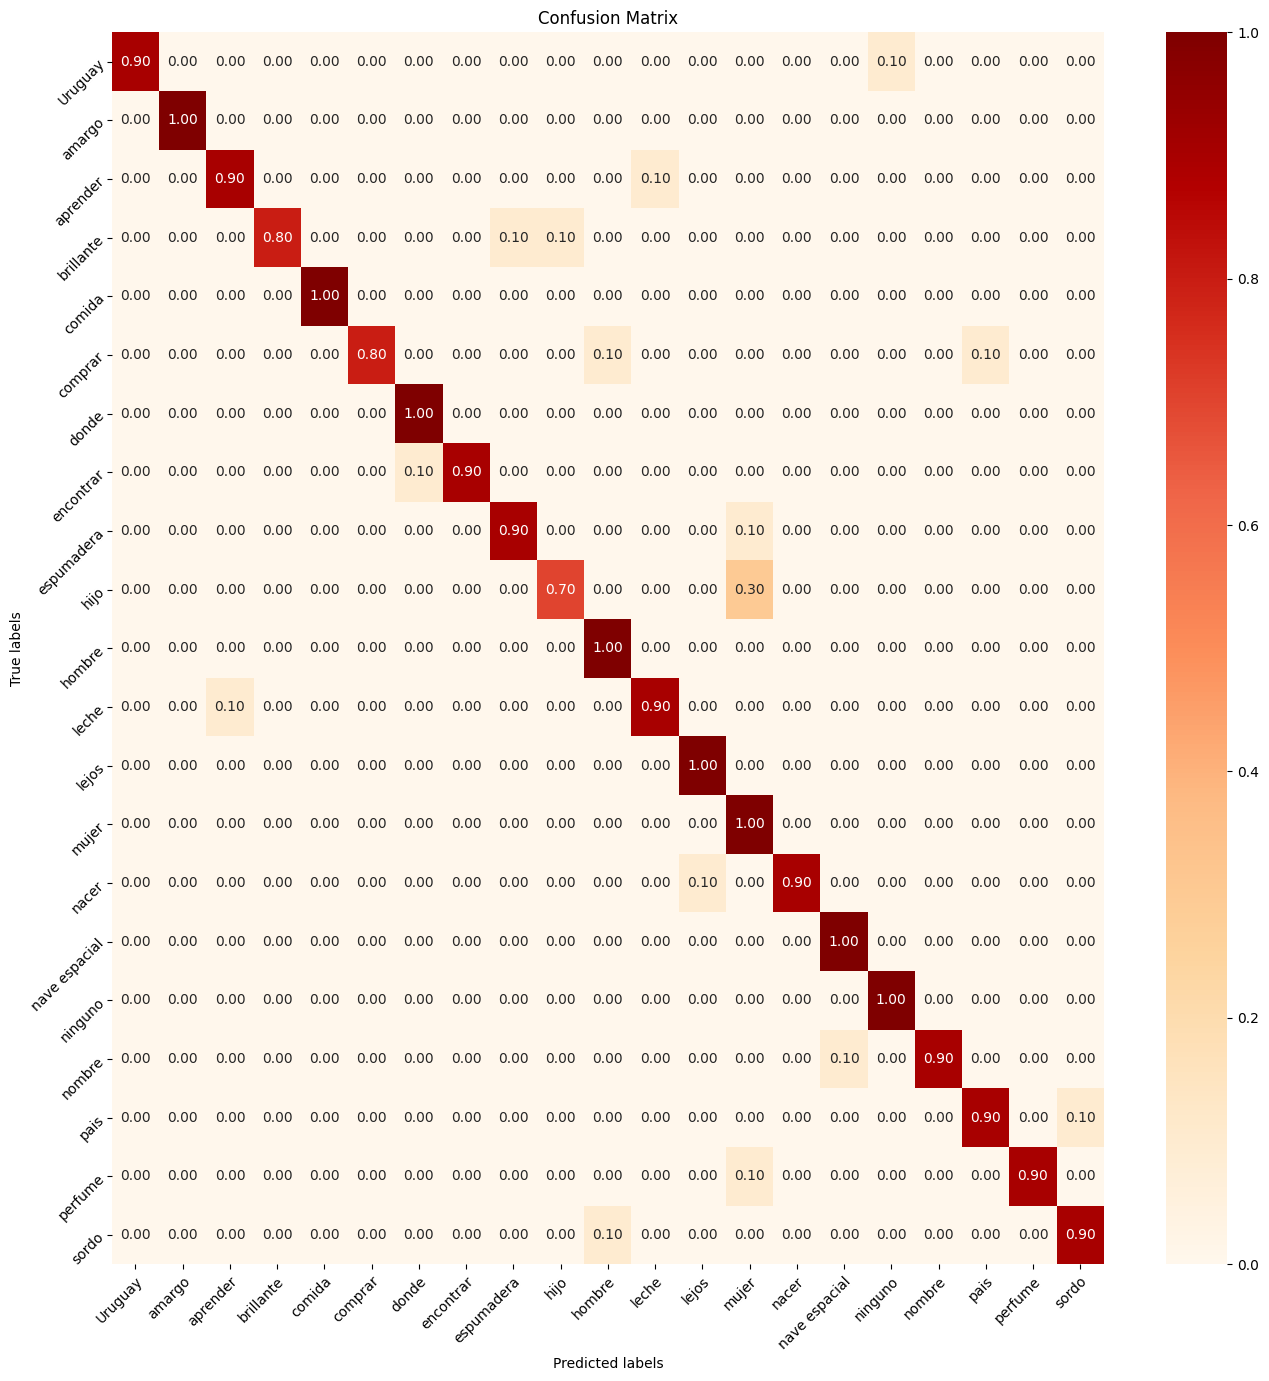

In [14]:
plot_matrix_confusion(X_test,y_test,le,modelxgb_opt)

In [15]:
y_pred = modelxgb_opt.predict(X_test)
reporting_table(y_test,y_pred,le)

C:\Users\facur\AppData\Local\Temp\ipykernel_4360\2673514020.py:110: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  return df_report.style.background_gradient(axis=None, subset=pd.IndexSlice[le.classes_[0]:le.classes_[-1], :df_report.columns[-2]],cmap="OrRd").set_precision(2)


,precision,recall,f1-score,support
Uruguay,1.00,0.90,0.95,10.00
amargo,1.00,1.00,1.00,10.00
aprender,0.90,0.90,0.90,10.00
brillante,1.00,0.80,0.89,10.00
comida,1.00,1.00,1.00,10.00
comprar,1.00,0.80,0.89,10.00
donde,0.91,1.00,0.95,10.00
encontrar,1.00,0.90,0.95,10.00
espumadera,0.90,0.90,0.90,10.00
hijo,0.88,0.70,0.78,10.00


# Modelo final prueba con partición de validación

In [16]:
test_xgb, test_dicc_xgb= metrics(y_valid, X_valid, modelxgb_opt)
test_xgb

,metrica,valor
0,precision,0.92
1,recall,0.91
2,f1,0.91
3,f05,0.91
4,f2,0.91
5,accuracy,0.91


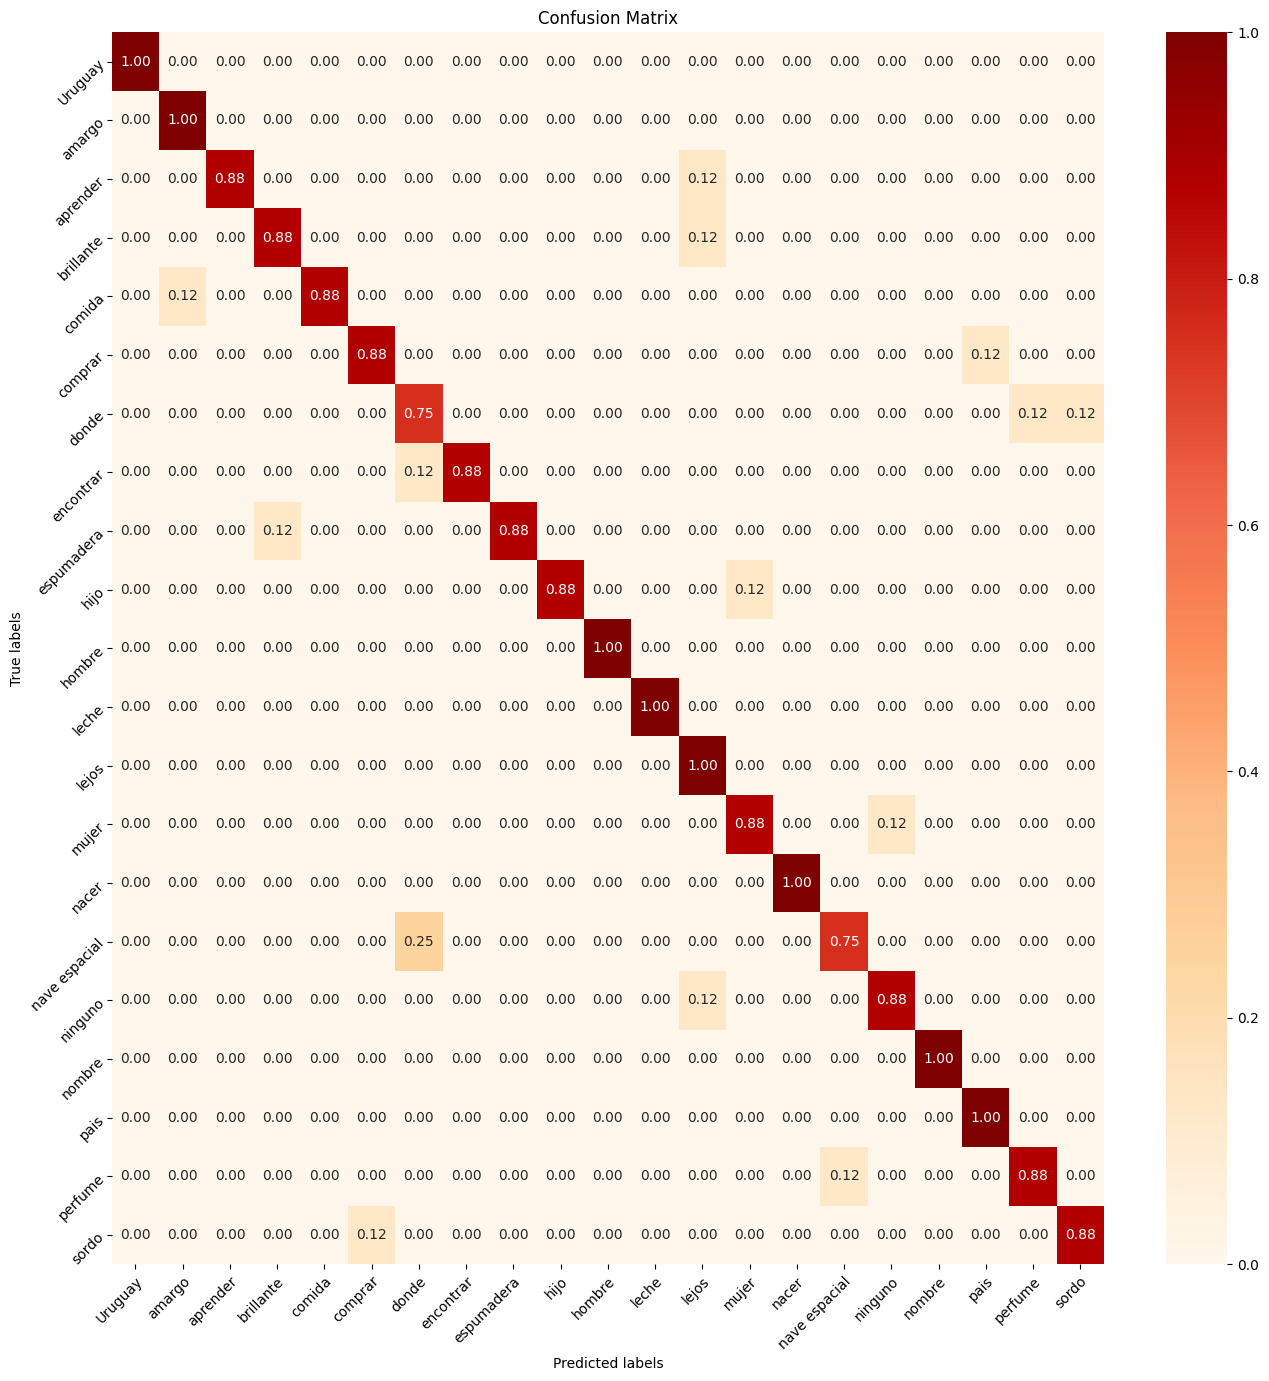

In [17]:
plot_matrix_confusion(X_valid,y_valid,le,modelxgb_opt)

In [18]:
y_pred = modelxgb_opt.predict(X_valid)
reporting_table(y_valid,y_pred,le)

C:\Users\facur\AppData\Local\Temp\ipykernel_4360\2673514020.py:110: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  return df_report.style.background_gradient(axis=None, subset=pd.IndexSlice[le.classes_[0]:le.classes_[-1], :df_report.columns[-2]],cmap="OrRd").set_precision(2)


,precision,recall,f1-score,support
Uruguay,1.00,1.00,1.00,8.00
amargo,0.89,1.00,0.94,8.00
aprender,1.00,0.88,0.93,8.00
brillante,0.88,0.88,0.88,8.00
comida,1.00,0.88,0.93,8.00
comprar,0.88,0.88,0.88,8.00
donde,0.67,0.75,0.71,8.00
encontrar,1.00,0.88,0.93,8.00
espumadera,1.00,0.88,0.93,8.00
hijo,1.00,0.88,0.93,8.00


# Guarado de modelo

In [19]:
import os
os.getcwd()

'c:\\Users\\facur\\Desktop\\tesis_LSA\\codigos_datos_tesis\\Notebooks\\Lengua Seña CLF\\02_modelado'

In [20]:
# Guardar modelo en joblib

#joblib.dump(modelxgb_base,'/00_modelos/03_xgboost_criterio_random_base.joblib')
joblib.dump(modelxgb_opt,'00_modelos/03_xgboost_criterio_random_10fr_no_face.joblib')

['00_modelos/03_xgboost_criterio_random_opt.joblib']